In [394]:
import sqlite3
import pandas as pd
from sqlite3 import Error 

In [2]:
with open('health_data.csv','r') as file:
    data = file.readlines()

In [24]:
data.shape

(70692, 18)

## Create Connection, Tables, and manipulate using SQL

In [4]:
def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn

In [5]:
def create_table(conn, create_table_sql):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

In [6]:
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

In [121]:
conn_health = create_connection("health_params.db",delete_db=True)

In [120]:
conn_health.close()

In [44]:
data[0]

'Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Diabetes,Hypertension,Stroke\n'

In [45]:
data[1]

'4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0\n'

In [38]:
float(data[1].strip().split(',')[0])

4.0

In [39]:
sex_dict = {0:'female',1:'male'}
chol_dict = {0:'no',1:'yes'}


### Create Tables

In [122]:
sql3 = """Create Table GenHealth(
        [GenHealthID] Integer NOT NULL PRIMARY KEY,
        [HealthCond] Text        
        ); """
create_table(conn_health,sql3)

gen_health_dict = {
    1 : 'Excellent',
    2 : 'Very Good',
    3 : 'Good',
    4 : 'Fair',
    5 : 'Poor'
}

gen_health_det = [(k,gen_health_dict[k]) for k in gen_health_dict.keys()]


sql = ''' INSERT INTO GenHealth(GenHealthID,HealthCond)
                    VALUES(?,?) '''

with conn_health:
    cur = conn_health.cursor()
    cur.executemany(sql, gen_health_det)

In [123]:
# Create Tables

sql = """Create Table Health(
        [ID] Integer NOT NULL PRIMARY KEY,
        [Age_Group] Integer,
        [Sex] Text,
        [HighChol] Text,
        [CholCheck] Text,
        [BMI] Real,
        [HeartDis] Text, 
        [GenHealthID] Integer, 
        [MentHealth] Integer, 
        [PhyHealth] Integer, 
        [DiffWalk] Text,
        FOREIGN KEY(GenHealthID) REFERENCES GenHealth(GenHealthID)
        );"""
create_table(conn_health,sql)


health_data = []
for i in range(1,len(data)):
    det = data[i].strip().split(',')
    health_data.append((i,float(det[0]),sex_dict[float(det[1])],chol_dict[float(det[2])],chol_dict[float(det[3])],float(det[4]),chol_dict[float(det[6])],float(det[11]),float(det[12]),float(det[13]),chol_dict[float(det[14])]))


sql = ''' INSERT INTO Health(ID,Age_Group,Sex,HighChol,CholCheck,BMI,HeartDis,GenHealthID,MentHealth,PhyHealth,DiffWalk)
                    VALUES(?,?,?,?,?,?,?,?,?,?,?) '''

with conn_health:
    cur = conn_health.cursor()
    cur.executemany(sql, health_data)

In [124]:
# Create Tables

sql2 = """Create Table Habits(
        [ID] Integer NOT NULL PRIMARY KEY,
        [Smoker] Integer,
        [PhyAct] Integer,
        [FruitCons] Integer,
        [VeggieCons] Integer,
        [AlchCons] Integer,
        FOREIGN KEY(ID) REFERENCES Health(ID)
        ) """
create_table(conn_health,sql2)


habits_data = []
for i in range(1,len(data)):
    det = data[i].strip().split(',')
    habits_data.append((i,chol_dict[float(det[5])],chol_dict[float(det[7])],chol_dict[float(det[8])],chol_dict[float(det[9])],chol_dict[float(det[10])]))


sql = ''' INSERT INTO Habits(ID,Smoker,PhyAct,FruitCons,VeggieCons,AlchCons)
                    VALUES(?,?,?,?,?,?) '''

with conn_health:
    cur = conn_health.cursor()
    cur.executemany(sql, habits_data)

In [125]:
# Create Tables

sql4 = """Create Table HealthCondition(
        [ID] Integer NOT NULL PRIMARY KEY,
        [Diabetes] Text,
        [HypTension] Text,
        [Stroke] Text,
        FOREIGN KEY(ID) REFERENCES Health(ID)
        ); """
create_table(conn_health,sql4)

health_cond_data = []
for i in range(1,len(data)):
    det = data[i].strip().split(',')
    health_cond_data.append((i,chol_dict[float(det[15])],chol_dict[float(det[16])],chol_dict[float(det[17])]))



sql = ''' INSERT INTO HealthCondition(ID,Diabetes,HypTension,Stroke)
                    VALUES(?,?,?,?) '''

with conn_health:
    cur = conn_health.cursor()
    cur.executemany(sql, health_cond_data)

### Data Manipulation

In [133]:
null_value_update = ['UPDATE Health SET Age_Group    = (SELECT AVG(Age_Group)    FROM Health) WHERE Age_Group IS NULL;',
                    'UPDATE Health SET BMI    = (SELECT AVG(BMI)    FROM Health) WHERE BMI IS NULL;',
                    'UPDATE Health SET MentHealth    = (SELECT AVG(MentHealth)    FROM Health) WHERE MentHealth IS NULL;',
                    'UPDATE Health SET PhyHealth    = (SELECT AVG(PhyHealth)    FROM Health) WHERE PhyHealth IS NULL;']

In [134]:
for sql in null_value_update:
    execute_sql_statement(sql, conn_health)

### Data Import using JOINS from DataBase

In [466]:
sql = """Select He.ID, He.Age_Group, He.Sex, He.HighChol, He.CholCheck, He.BMI, He.HeartDis,
        He.MentHealth, He.PhyHealth, He.DiffWalk,
        Ha.Smoker,Ha.PhyAct,Ha.FruitCons,Ha.VeggieCons,Ha.AlchCons,
        G.HealthCond,
        HC.Diabetes,HC.HypTension,HC.Stroke
        from Health He
        left join Habits Ha on He.ID = Ha.ID
        left join GenHealth G
        on He.GenHealthID = G.GenHealthID
        left join HealthCondition HC
        on He.ID = HC.ID
        group by He.ID;"""

In [467]:
df = pd.read_sql_query(sql,conn_health)

In [468]:
df.head()

,ID,Age_Group,Sex,HighChol,CholCheck,BMI,HeartDis,MentHealth,PhyHealth,DiffWalk,Smoker,PhyAct,FruitCons,VeggieCons,AlchCons,HealthCond,Diabetes,HypTension,Stroke
0,1,4,male,no,yes,26.0,no,5,30,no,no,yes,no,yes,no,Good,no,yes,no
1,2,12,male,yes,yes,26.0,no,0,0,no,yes,no,yes,no,no,Good,no,yes,yes
2,3,13,male,no,yes,26.0,no,0,10,no,no,yes,yes,yes,no,Excellent,no,no,no
3,4,11,male,yes,yes,28.0,no,0,3,no,yes,yes,yes,yes,no,Good,no,yes,no
4,5,8,female,no,yes,29.0,no,0,0,no,yes,yes,yes,yes,no,Very Good,no,no,no


### Exploratory Data Analysis and Feature Extraction 

In [469]:
df.columns,df.shape

(Index(['ID', 'Age_Group', 'Sex', 'HighChol', 'CholCheck', 'BMI', 'HeartDis',
        'MentHealth', 'PhyHealth', 'DiffWalk', 'Smoker', 'PhyAct', 'FruitCons',
        'VeggieCons', 'AlchCons', 'HealthCond', 'Diabetes', 'HypTension',
        'Stroke'],
       dtype='object'),
 (70692, 19))

In [470]:
df.isna().sum()

ID            0
Age_Group     0
Sex           0
HighChol      0
CholCheck     0
BMI           0
HeartDis      0
MentHealth    0
PhyHealth     0
DiffWalk      0
Smoker        0
PhyAct        0
FruitCons     0
VeggieCons    0
AlchCons      0
HealthCond    0
Diabetes      0
HypTension    0
Stroke        0
dtype: int64

In [471]:
sex_dict = {'female':0,'male':1}
chol_dict = {'no':0,'yes':1}
gen_health_dict = {
    'Excellent' : 1,
    'Very Good':2,
    'Good':3,
    'Fair':4,
    'Poor':5
}


In [472]:
df = df.replace({"Sex": sex_dict})
df = df.replace({"HealthCond" : gen_health_dict})

In [473]:
## Conversion of Categorical Features
cat_columns = df.select_dtypes(include='object')

In [474]:
for i in cat_columns:
    df = df.replace({i:chol_dict})

In [475]:
df = df.drop(columns = ['ID'])

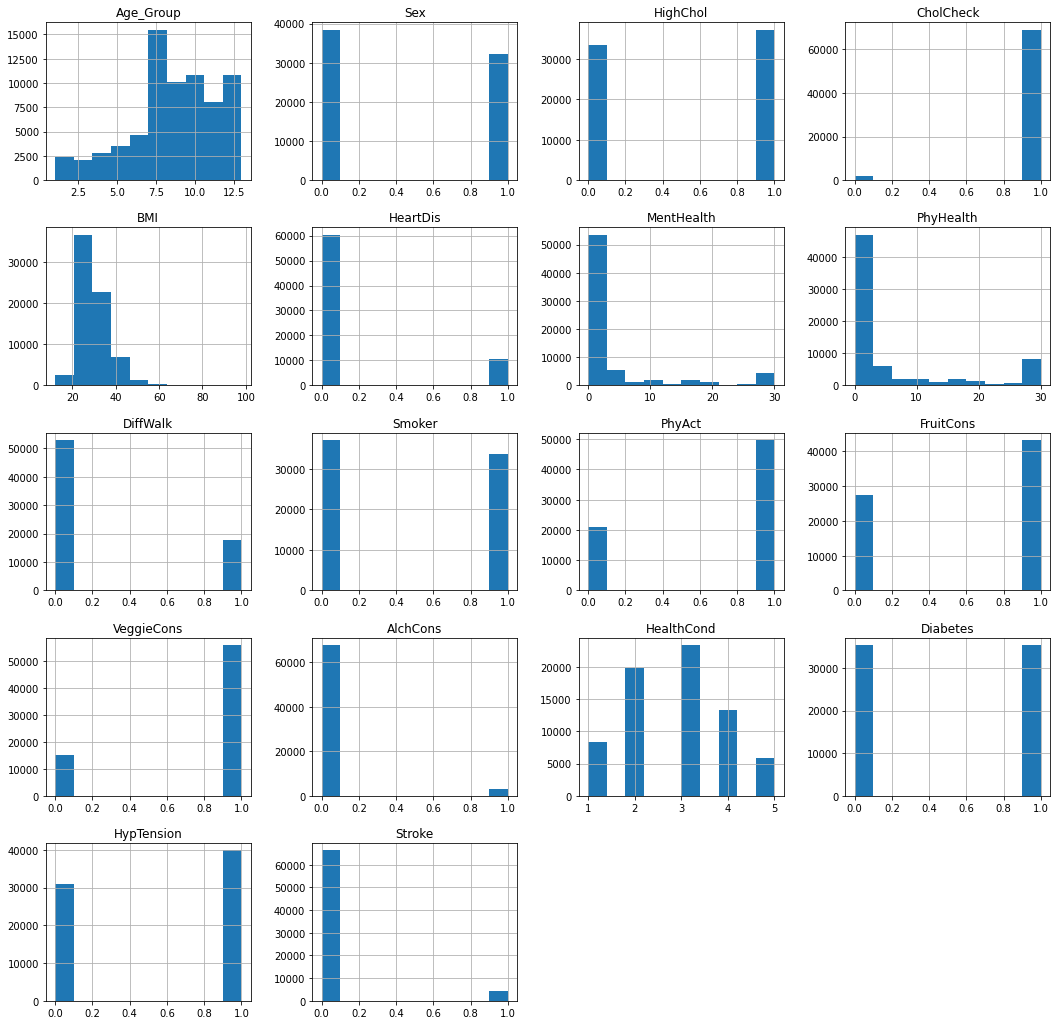

In [476]:
import matplotlib.pyplot as plt
df.hist(figsize=(18,18))
plt.show()

In [477]:
df[df['Sex']==1]['Stroke'].value_counts()

0    30265
1     2041
Name: Stroke, dtype: int64

In [478]:
df[df['Sex']==0]['Stroke'].value_counts()

0    36032
1     2354
Name: Stroke, dtype: int64

In [479]:
df = df.drop(columns=['CholCheck','Diabetes'])

In [480]:
df['Overall_Health'] = df['MentHealth'] + df['PhyHealth']
df['diet_n_workout'] = df['PhyAct'] + df['FruitCons'] + df['VeggieCons']
df['smoke_n_drink'] = df['Smoker'] + df['AlchCons']


df = df.drop(columns=['MentHealth','PhyHealth','PhyAct','FruitCons','VeggieCons','Smoker','AlchCons'])

In [481]:
main_df = df

In [425]:
df.to_csv('Updated_df.csv',index=False)

In [427]:
df['Stroke_dummy'] = df['Stroke']
df_age_stroke = df.groupby(['Age_Group','Stroke'])['Stroke_dummy'].count().reset_index()

,Age_Group,Stroke,Stroke_dummy_x,Stroke_dummy_y,stroke_percent
1,1,1,4,979,0.41
3,2,1,7,1396,0.50
5,3,1,19,2049,0.93
7,4,1,44,2793,1.58
9,5,1,67,3520,1.90
11,6,1,124,4648,2.67
13,7,1,303,6872,4.41
15,8,1,493,8603,5.73
17,9,1,674,10112,6.67
19,10,1,783,10856,7.21


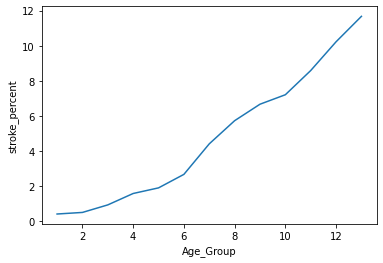

In [429]:
df_age_stroke = df_age_stroke.merge(df_age_stroke.groupby(['Age_Group'])['Stroke_dummy'].sum().reset_index(),on = 'Age_Group',how='left')
df_age_stroke['stroke_percent'] = round((df_age_stroke.Stroke_dummy_x /df_age_stroke.Stroke_dummy_y)*100,2)

df_age_stroke = df_age_stroke[df_age_stroke['Stroke']==1]

sns.lineplot(x=df_age_stroke['Age_Group'],y=df_age_stroke['stroke_percent'])
plt.xlabel('Age_Group')
df_age_stroke

,Sex,Stroke,Stroke_dummy_x,Stroke_dummy_y,stroke_percent
1,0,1,2354,38386,6.13
3,1,1,2041,32306,6.32


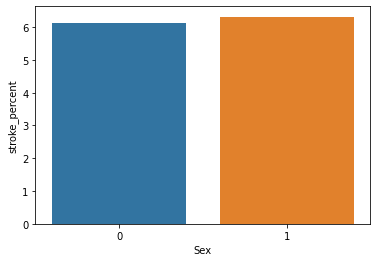

In [430]:
df_sex_stroke = df.groupby(['Sex','Stroke'])['Stroke_dummy'].count().reset_index()

df_sex_stroke = df_sex_stroke.merge(df_sex_stroke.groupby(['Sex'])['Stroke_dummy'].sum().reset_index(),on = 'Sex',how='left')
df_sex_stroke['stroke_percent'] = round((df_sex_stroke.Stroke_dummy_x /df_sex_stroke.Stroke_dummy_y)*100,2)

df_sex_stroke = df_sex_stroke[df_sex_stroke['Stroke']==1]

sns.barplot(x=df_sex_stroke['Sex'],y=df_sex_stroke['stroke_percent'])
df_sex_stroke

In [431]:
df_highchol_stroke = df.groupby(['HighChol','Stroke'])['Stroke_dummy'].count().reset_index()

,HighChol,Stroke,Stroke_dummy_x,Stroke_dummy_y,stroke_percent
1,0,1,1234,33529,3.68
3,1,1,3161,37163,8.51


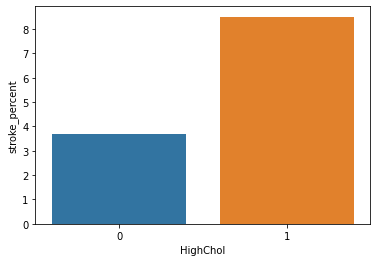

In [432]:
df_highchol_stroke = df_highchol_stroke.merge(df_highchol_stroke.groupby(['HighChol'])['Stroke_dummy'].sum().reset_index(),on = 'HighChol',how='left')
df_highchol_stroke['stroke_percent'] = round((df_highchol_stroke.Stroke_dummy_x /df_highchol_stroke.Stroke_dummy_y)*100,2)

df_highchol_stroke = df_highchol_stroke[df_highchol_stroke['Stroke']==1]

sns.barplot(x=df_highchol_stroke['HighChol'],y=df_highchol_stroke['stroke_percent'])
df_highchol_stroke

In [436]:
df['stroke_dummy'] =df['Stroke']
df_bmi_stroke = df.groupby(['diet_n_workout','Stroke'])['stroke_dummy'].count().reset_index()

In [437]:
df_bmi_stroke

,diet_n_workout,Stroke,stroke_dummy
0,0,0,3804
1,0,1,432
2,1,0,12063
3,1,1,1040
4,2,0,22860
5,2,1,1594
6,3,0,27570
7,3,1,1329


,diet_n_workout,Stroke,stroke_dummy_x,stroke_dummy_y,stroke_percent
1,0,1,432,4236,10.20
3,1,1,1040,13103,7.94
5,2,1,1594,24454,6.52
7,3,1,1329,28899,4.60


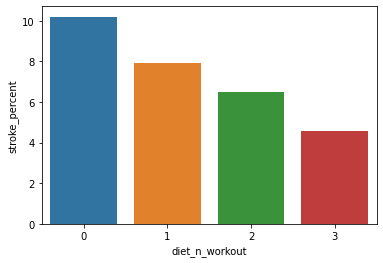

In [438]:
df_bmi_stroke = df_bmi_stroke.merge(df_bmi_stroke.groupby(['diet_n_workout'])['stroke_dummy'].sum().reset_index(),on = 'diet_n_workout',how='left')
df_bmi_stroke['stroke_percent'] = round((df_bmi_stroke.stroke_dummy_x /df_bmi_stroke.stroke_dummy_y)*100,2)

df_bmi_stroke = df_bmi_stroke[(df_bmi_stroke['Stroke']==1)]

sns.barplot(x=df_bmi_stroke['diet_n_workout'],y=df_bmi_stroke['stroke_percent'])
df_bmi_stroke

In [439]:
df_hyptension_stroke = df.groupby(['HypTension','Stroke'])['stroke_dummy'].count().reset_index()

,HypTension,Stroke,stroke_dummy
1,0,1,826
3,1,1,3569


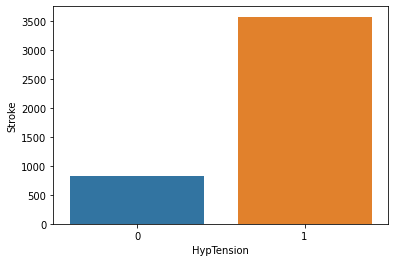

In [440]:
df_hyptension_stroke = df_hyptension_stroke[df_hyptension_stroke['Stroke'] == 1]
sns.barplot(x =df_hyptension_stroke['HypTension'],y = df_hyptension_stroke['stroke_dummy'])
plt.ylabel('Stroke')
df_hyptension_stroke

In [441]:
df.head(2)

,Age_Group,Sex,HighChol,BMI,HeartDis,DiffWalk,HealthCond,HypTension,Stroke,Overall_Health,diet_n_workout,smoke_n_drink,Stroke_dummy,stroke_dummy
0,4,1,0,26.0,0,0,3,1,0,35,2,0,0,0
1,12,1,1,26.0,0,0,3,1,1,0,1,1,1,1


In [442]:
df.corr()

,Age_Group,Sex,HighChol,BMI,HeartDis,DiffWalk,HealthCond,HypTension,Stroke,Overall_Health,diet_n_workout,smoke_n_drink,Stroke_dummy,stroke_dummy
Age_Group,1.000000,-0.002315,0.240338,-0.038648,0.221878,0.195265,0.155624,0.338132,0.123879,0.001582,-0.026424,0.074077,0.123879,0.123879
Sex,-0.002315,1.000000,0.017324,0.000827,0.098161,-0.082248,-0.014555,0.040819,0.003822,-0.078433,-0.045261,0.106401,0.003822,0.003822
HighChol,0.240338,0.017324,1.000000,0.131309,0.181187,0.162043,0.237778,0.316515,0.099786,0.139675,-0.090280,0.075015,0.099786,0.099786
BMI,-0.038648,0.000827,0.131309,1.000000,0.060355,0.246094,0.267888,0.241019,0.022931,0.163625,-0.156914,-0.010860,0.022931,0.022931
HeartDis,0.221878,0.098161,0.181187,0.060355,1.000000,0.232611,0.275868,0.210750,0.223394,0.171943,-0.076247,0.098746,0.223394,0.223394
DiffWalk,0.195265,-0.082248,0.162043,0.246094,0.232611,1.000000,0.476639,0.234784,0.192266,0.458831,-0.204543,0.090120,0.192266,0.192266
HealthCond,0.155624,-0.014555,0.237778,0.267888,0.275868,0.476639,1.000000,0.320540,0.189447,0.535978,-0.242875,0.116101,0.189447,0.189447
HypTension,0.338132,0.040819,0.316515,0.241019,0.210750,0.234784,0.320540,1.000000,0.129060,0.149912,-0.120464,0.069055,0.129060,0.129060
Stroke,0.123879,0.003822,0.099786,0.022931,0.223394,0.192266,0.189447,0.129060,1.000000,0.156024,-0.066531,0.049819,1.000000,1.000000
Overall_Health,0.001582,-0.078433,0.139675,0.163625,0.171943,0.458831,0.535978,0.149912,0.156024,1.000000,-0.181409,0.110832,0.156024,0.156024


In [443]:
df_smoke_n_drink_stroke = df[df['smoke_n_drink']!=0]

In [444]:
df_smoke_n_drink_stroke = df_smoke_n_drink_stroke.groupby(['smoke_n_drink','HeartDis','Stroke'])['stroke_dummy'].count().reset_index()

In [445]:
df_smoke_n_drink_stroke

,smoke_n_drink,HeartDis,Stroke,stroke_dummy
0,1,0,0,24937
1,1,0,1,1312
2,1,1,0,5116
3,1,1,1,1271
4,2,0,0,1742
5,2,0,1,51
6,2,1,0,167
7,2,1,1,31


,smoke_n_drink,HeartDis,Stroke,stroke_dummy_x,stroke_dummy_y,stroke_percent
1,1,0,1,1312,26249,5.00
3,1,1,1,1271,6387,19.90
5,2,0,1,51,1793,2.84
7,2,1,1,31,198,15.66


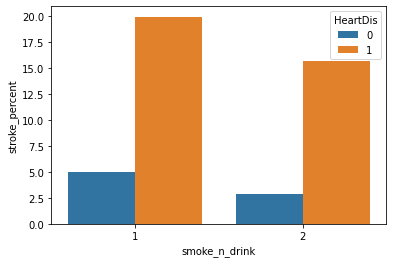

In [446]:
df_smoke_n_drink_stroke = df_smoke_n_drink_stroke.merge(df_smoke_n_drink_stroke.groupby(['smoke_n_drink','HeartDis'])['stroke_dummy'].sum().reset_index(),on = ['smoke_n_drink','HeartDis'],how='left')
df_smoke_n_drink_stroke['stroke_percent'] = round((df_smoke_n_drink_stroke.stroke_dummy_x /df_smoke_n_drink_stroke.stroke_dummy_y)*100,2)

df_smoke_n_drink_stroke = df_smoke_n_drink_stroke[(df_smoke_n_drink_stroke['Stroke']==1)]

sns.barplot(x=df_smoke_n_drink_stroke['smoke_n_drink'],y=df_smoke_n_drink_stroke['stroke_percent'],hue=df_smoke_n_drink_stroke['HeartDis'])
df_smoke_n_drink_stroke

In [447]:
df.columns

Index(['Age_Group', 'Sex', 'HighChol', 'BMI', 'HeartDis', 'DiffWalk',
       'HealthCond', 'HypTension', 'Stroke', 'Overall_Health',
       'diet_n_workout', 'smoke_n_drink', 'Stroke_dummy', 'stroke_dummy'],
      dtype='object')

In [448]:
df.groupby(['HealthCond','DiffWalk','Stroke'])['stroke_dummy'].count().reset_index()

,HealthCond,DiffWalk,Stroke,stroke_dummy
0,1,0,0,7875
1,1,0,1,89
2,1,1,0,285
3,1,1,1,33
4,2,0,0,17924
5,2,0,1,403
6,2,1,0,1429
7,2,1,1,116
8,3,0,0,17779
9,3,0,1,729


### Model Training

In [451]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import random
from sklearn.metrics import accuracy_score,classification_report,plot_confusion_matrix

In [465]:
df

,Age_Group,Sex,HighChol,BMI,HeartDis,DiffWalk,HealthCond,HypTension,Stroke,Overall_Health,diet_n_workout,smoke_n_drink,Stroke_dummy,stroke_dummy
0,4,1,0,26.0,0,0,3,1,0,35,2,0,0,0
1,12,1,1,26.0,0,0,3,1,1,0,1,1,1,1
2,13,1,0,26.0,0,0,1,0,0,10,3,0,0,0
3,11,1,1,28.0,0,0,3,1,0,3,3,1,0,0
4,8,0,0,29.0,0,0,2,0,0,0,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,6,0,1,37.0,0,0,4,0,0,0,1,0,0,0
70688,10,1,1,29.0,1,1,2,0,0,0,2,1,0,0
70689,13,0,1,25.0,1,1,5,1,0,15,1,0,0,0
70690,11,0,1,18.0,0,1,4,1,0,0,0,0,0,0


In [482]:
random.seed(42)
X_train,X_test,Y_train,Y_test = train_test_split(main_df.drop(columns=['HypTension','Stroke']),main_df['Stroke'],test_size=0.3,stratify=main_df['HypTension'],shuffle=True)

In [483]:
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(49484, 10) (21208, 10) (49484,) (21208,)


In [484]:
df['Stroke'].value_counts()

0    66297
1     4395
Name: Stroke, dtype: int64

In [486]:
main_df.corr()

,Age_Group,Sex,HighChol,BMI,HeartDis,DiffWalk,HealthCond,HypTension,Stroke,Overall_Health,diet_n_workout,smoke_n_drink
Age_Group,1.000000,-0.002315,0.240338,-0.038648,0.221878,0.195265,0.155624,0.338132,0.123879,0.001582,-0.026424,0.074077
Sex,-0.002315,1.000000,0.017324,0.000827,0.098161,-0.082248,-0.014555,0.040819,0.003822,-0.078433,-0.045261,0.106401
HighChol,0.240338,0.017324,1.000000,0.131309,0.181187,0.162043,0.237778,0.316515,0.099786,0.139675,-0.090280,0.075015
BMI,-0.038648,0.000827,0.131309,1.000000,0.060355,0.246094,0.267888,0.241019,0.022931,0.163625,-0.156914,-0.010860
HeartDis,0.221878,0.098161,0.181187,0.060355,1.000000,0.232611,0.275868,0.210750,0.223394,0.171943,-0.076247,0.098746
DiffWalk,0.195265,-0.082248,0.162043,0.246094,0.232611,1.000000,0.476639,0.234784,0.192266,0.458831,-0.204543,0.090120
HealthCond,0.155624,-0.014555,0.237778,0.267888,0.275868,0.476639,1.000000,0.320540,0.189447,0.535978,-0.242875,0.116101
HypTension,0.338132,0.040819,0.316515,0.241019,0.210750,0.234784,0.320540,1.000000,0.129060,0.149912,-0.120464,0.069055
Stroke,0.123879,0.003822,0.099786,0.022931,0.223394,0.192266,0.189447,0.129060,1.000000,0.156024,-0.066531,0.049819
Overall_Health,0.001582,-0.078433,0.139675,0.163625,0.171943,0.458831,0.535978,0.149912,0.156024,1.000000,-0.181409,0.110832


#### Logistic Regression

In [1]:
model = LogisticRegression(penalty= 'l2' ,max_iter=10,solver='liblinear',class_weight= 'balanced').fit(X = X_train,y = Y_train)

In [488]:
y_pred = model.predict(X_test)

In [489]:
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.73      0.84     19899
           1       0.15      0.72      0.25      1309

    accuracy                           0.73     21208
   macro avg       0.56      0.73      0.54     21208
weighted avg       0.92      0.73      0.80     21208



In [2]:
#plot_confusion_matrix(model,X_test,Y_test)

#### Random Forest Classifier

In [491]:
model2 = RandomForestClassifier(class_weight= 'balanced',max_depth = 8).fit(X = X_train,y = Y_train)

In [492]:
y_pred2 = model2.predict(X_test)

In [493]:
print(classification_report(Y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.97      0.74      0.84     19899
           1       0.15      0.70      0.25      1309

    accuracy                           0.74     21208
   macro avg       0.56      0.72      0.55     21208
weighted avg       0.92      0.74      0.81     21208



In [3]:
#plot_confusion_matrix(model,X_test,Y_test)

Logistic: ROC AUC=0.729
RF: ROC AUC=0.720


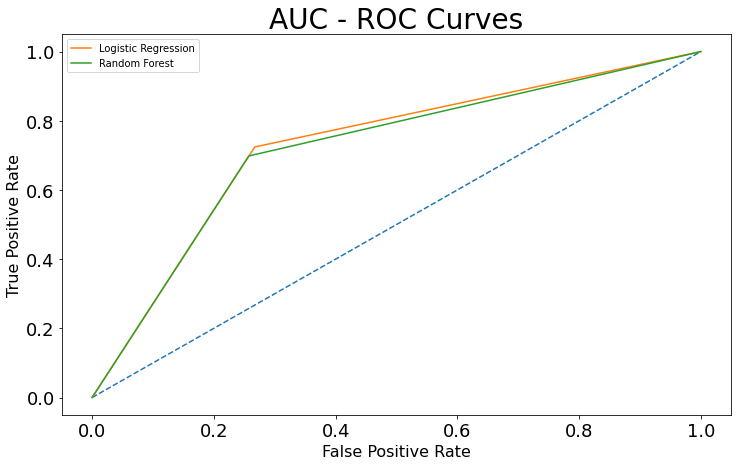

In [495]:
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
fpr2, tpr2, thresholds = roc_curve(Y_test, y_pred2)

lr_auc = roc_auc_score(Y_test, y_pred)
rf_auc = roc_auc_score(Y_test, y_pred2)

print('Logistic: ROC AUC=%.3f' % (lr_auc))
print('RF: ROC AUC=%.3f' % (rf_auc))


plt.figure(figsize = (12,7))
plt.plot([0, 1], [0, 1], linestyle = '--')

plt.plot(fpr, tpr,label = "Logistic Regression")
plt.plot(fpr2, tpr2,label = "Random Forest")

plt.xlabel('False Positive Rate', fontsize = 16)
plt.ylabel('True Positive Rate', fontsize = 16)

plt.xticks(size = 18)
plt.yticks(size = 18)

plt.title('AUC - ROC Curves', fontsize = 28)
plt.legend()
plt.show();

## User Input

In [392]:
d = {'Age_Group':[1],'Sex':1,'HighChol':0,'BMI':24.0,'HeartDis':0,'DiffWalk':0,'HealthCond':2,'Overall_Health':5,'diet_n_workout':3,'smoke_n_drink':0}

In [393]:
model.predict(pd.DataFrame.from_dict(d))

array([0], dtype=int64)